In [96]:
import os
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [2]:
#pulling data from github repo
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
df = pd.read_csv(DATA_URL,
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)
df.drop(['M1_Wildcard'], axis=1, inplace = True)

In [3]:
df.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174720 entries, 0 to 174719
Data columns (total 50 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   CountryName                            174720 non-null  object        
 1   CountryCode                            174720 non-null  object        
 2   RegionName                             70560 non-null   object        
 3   RegionCode                             70560 non-null   object        
 4   Jurisdiction                           174720 non-null  object        
 5   Date                                   174720 non-null  datetime64[ns]
 6   C1_School closing                      170257 non-null  float64       
 7   C1_Flag                                138284 non-null  float64       
 8   C2_Workplace closing                   170196 non-null  float64       
 9   C2_Flag                                133619 no

In [5]:
df.sample(5)

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
80173,Guatemala,GTM,NaN,NaN,NAT_TOTAL,2020-04-03,3.0,1.0,3.0,1.0,2.0,1.0,4.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,3.0,0.0,NaN,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,2.0,1.0,50.0,1.0,93.52,93.52,96.43,96.43,60.94,60.94,69.64,69.64,0.0,0.0
47089,China,CHN,Heilongjiang,CHN_HL,STATE_TOTAL,2020-02-19,3.0,1.0,2.0,1.0,2.0,1.0,4.0,1.0,2.0,0.0,3.0,0.0,2.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,0.0,NaN,2.0,1.0,470.0,12.0,83.33,83.33,80.95,80.95,72.40,72.40,73.81,73.81,62.5,62.5
20456,Brazil,BRA,Para,BR_PA,STATE_TOTAL,2020-10-23,2.0,1.0,2.0,0.0,2.0,1.0,3.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,1.0,NaN,NaN,2.0,1.0,2.0,2.0,NaN,NaN,4.0,1.0,0.0,NaN,1.0,1.0,246605.0,6717.0,54.17,54.17,61.90,61.90,52.34,52.34,56.25,56.25,25.0,25.0
104515,Malta,MLT,NaN,NaN,NAT_TOTAL,2020-12-21,1.0,1.0,2.0,1.0,2.0,1.0,4.0,1.0,0.0,NaN,0.0,NaN,0.0,NaN,3.0,2.0,0.0,1.0,NaN,NaN,2.0,1.0,3.0,2.0,NaN,NaN,4.0,1.0,0.0,NaN,2.0,1.0,11802.0,194.0,52.78,52.78,57.14,57.14,60.42,60.42,60.12,60.12,62.5,62.5
50960,China,CHN,Ningxia,CHN_NX,STATE_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0


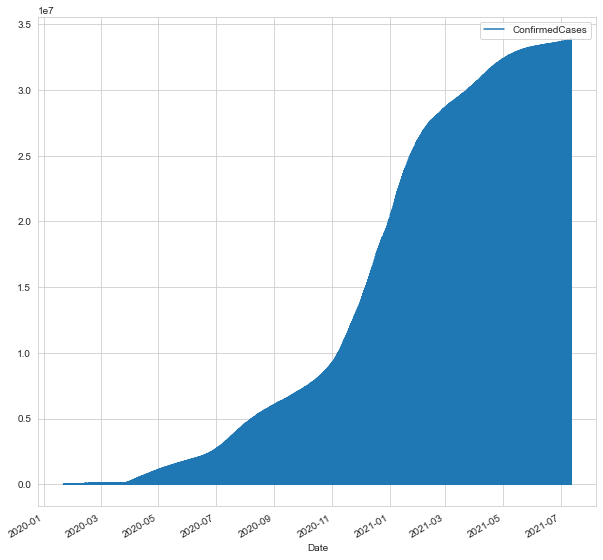

In [6]:
#Number of confirmed cases worldwide since the start of the pandemic
df.plot(x='Date',y='ConfirmedCases', figsize = (10,10))
plt.savefig('temp.png')

In [7]:
df.loc[(df.Date == '2021-01-01') & (df['ConfirmedCases'].isna()),'ConfirmedCases'] = 0

df['ConfirmedCases'].fillna(method = 'ffill', inplace = True)

df.loc[(df.Date == '2021-01-01') & (df['ConfirmedDeaths'].isna()),'ConfirmedDeaths'] = 0

df['ConfirmedDeaths'].fillna(method = 'ffill', inplace = True)

In [8]:
df[df['RegionName']=='Quebec'].head(50)

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
36960,Canada,CAN,Quebec,CAN_QC,STATE_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,1.0,1.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,208.0,0.0,5.56,5.56,9.52,9.52,3.12,3.12,3.57,3.57,0.0,0.0
36961,Canada,CAN,Quebec,CAN_QC,STATE_TOTAL,2020-01-02,0.0,NaN,0.0,NaN,1.0,1.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,208.0,0.0,5.56,5.56,9.52,9.52,3.12,3.12,3.57,3.57,0.0,0.0
36962,Canada,CAN,Quebec,CAN_QC,STATE_TOTAL,2020-01-03,0.0,NaN,0.0,NaN,1.0,1.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,208.0,0.0,5.56,5.56,9.52,9.52,3.12,3.12,3.57,3.57,0.0,0.0
36963,Canada,CAN,Quebec,CAN_QC,STATE_TOTAL,2020-01-04,0.0,NaN,0.0,NaN,1.0,1.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,208.0,0.0,5.56,5.56,9.52,9.52,3.12,3.12,3.57,3.57,0.0,0.0
36964,Canada,CAN,Quebec,CAN_QC,STATE_TOTAL,2020-01-05,0.0,NaN,0.0,NaN,1.0,1.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,208.0,0.0,5.56,5.56,9.52,9.52,3.12,3.12,3.57,3.57,0.0,0.0
36965,Canada,CAN,Quebec,CAN_QC,STATE_TOTAL,2020-01-06,0.0,NaN,0.0,NaN,1.0,1.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,208.0,0.0,5.56,5.56,9.52,9.52,3.12,3.12,3.57,3.57,0.0,0.0
36966,Canada,CAN,Quebec,CAN_QC,STATE_TOTAL,2020-01-07,0.0,NaN,0.0,NaN,1.0,1.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,208.0,0.0,5.56,5.56,9.52,9.52,3.12,3.12,3.57,3.57,0.0,0.0
36967,Canada,CAN,Quebec,CAN_QC,STATE_TOTAL,2020-01-08,0.0,NaN,0.0,NaN,1.0,1.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,208.0,0.0,5.56,5.56,9.52,9.52,3.12,3.12,3.57,3.57,0.0,0.0
36968,Canada,CAN,Quebec,CAN_QC,STATE_TOTAL,2020-01-09,0.0,NaN,0.0,NaN,1.0,1.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,208.0,0.0,5.56,5.56,9.52,9.52,3.12,3.12,3.57,3.57,0.0,0.0
36969,Canada,CAN,Quebec,CAN_QC,STATE_TOTAL,2020-01-10,0.0,NaN,0.0,NaN,1.0,1.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,208.0,0.0,5.56,5.56,9.52,9.52,3.12,3.12,3.57,3.57,0.0,0.0


In [9]:
df.Jurisdiction.value_counts()

NAT_TOTAL      104160
STATE_TOTAL     70560
Name: Jurisdiction, dtype: int64

In [10]:
#Dataframes for a state and province level, from here we can develop new features indicating the number of new deaths and cases from a National (Canada) and provincial view for further examination
country_df = df[df['Jurisdiction'] == 'NAT_TOTAL'].reset_index()
province_df = df[df['Jurisdiction'] == 'STATE_TOTAL'].reset_index()

#New Cases Feature
country_df['NewCases'] = country_df.groupby(by = 'CountryName').ConfirmedCases.diff().fillna(0)
province_df['NewCases'] = province_df.groupby(by = 'RegionName').ConfirmedCases.diff().fillna(0)

#New Deaths Feature
country_df['NewDeaths'] = country_df.groupby(by = 'CountryName').ConfirmedDeaths.diff().fillna(0)
province_df['NewDeaths'] = province_df.groupby(by = 'RegionName').ConfirmedDeaths.diff().fillna(0)

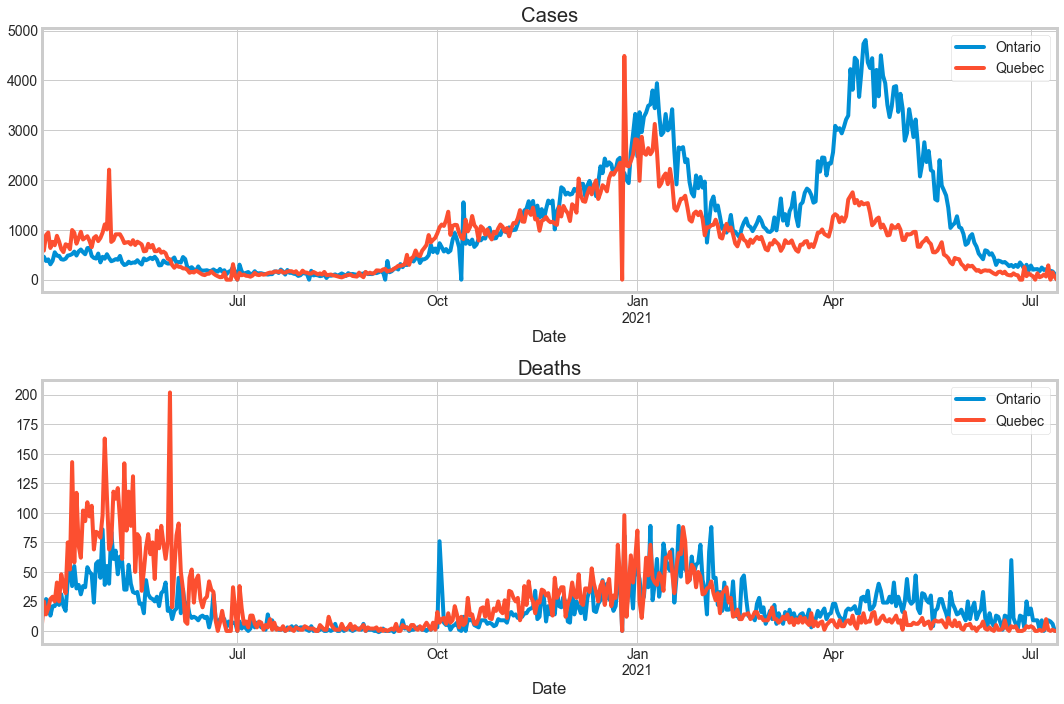

<Figure size 1080x720 with 0 Axes>

In [118]:
ax = plt.subplot(211)
ax2 = plt.subplot(212)

province_df[province_df['RegionName'] == 'Ontario'].plot(x='Date', y='NewCases', 
                                                      ax=ax, label = 'Ontario', title = 'Cases')

province_df[province_df['RegionName'] == 'Quebec'].plot(x='Date', y='NewCases', 
                                                    ax=ax, label = 'Quebec')




province_df[province_df['RegionName'] == 'Ontario'].plot(x='Date', y='NewDeaths', title = 'Deaths',
                                                      ax=ax2, label = 'Ontario')
province_df[province_df['RegionName'] == 'Quebec'].plot(x='Date', y='NewDeaths', 
                                                    ax=ax2, label = 'Quebec')
plt.tight_layout()
plt.show()
plt.savefig('Quebec-Ontario Cases Deaths.png')

In [12]:
province_df.to_csv('Data/province_df.csv')
country_df.to_csv('Data/country_df.csv')

In [13]:
province_df = province_df[province_df.Date > "2020-04-01"]

In [14]:
plt.figure(figsize = (10,10))
provinces = province_df[province_df['CountryName'] == 'Canada'].RegionName.unique()

provinces = provinces.tolist()
for i in provinces:
    if i in ['Northwest Territories','Nunavut','Yukon']:
        provinces.remove(i)


<Figure size 720x720 with 0 Axes>

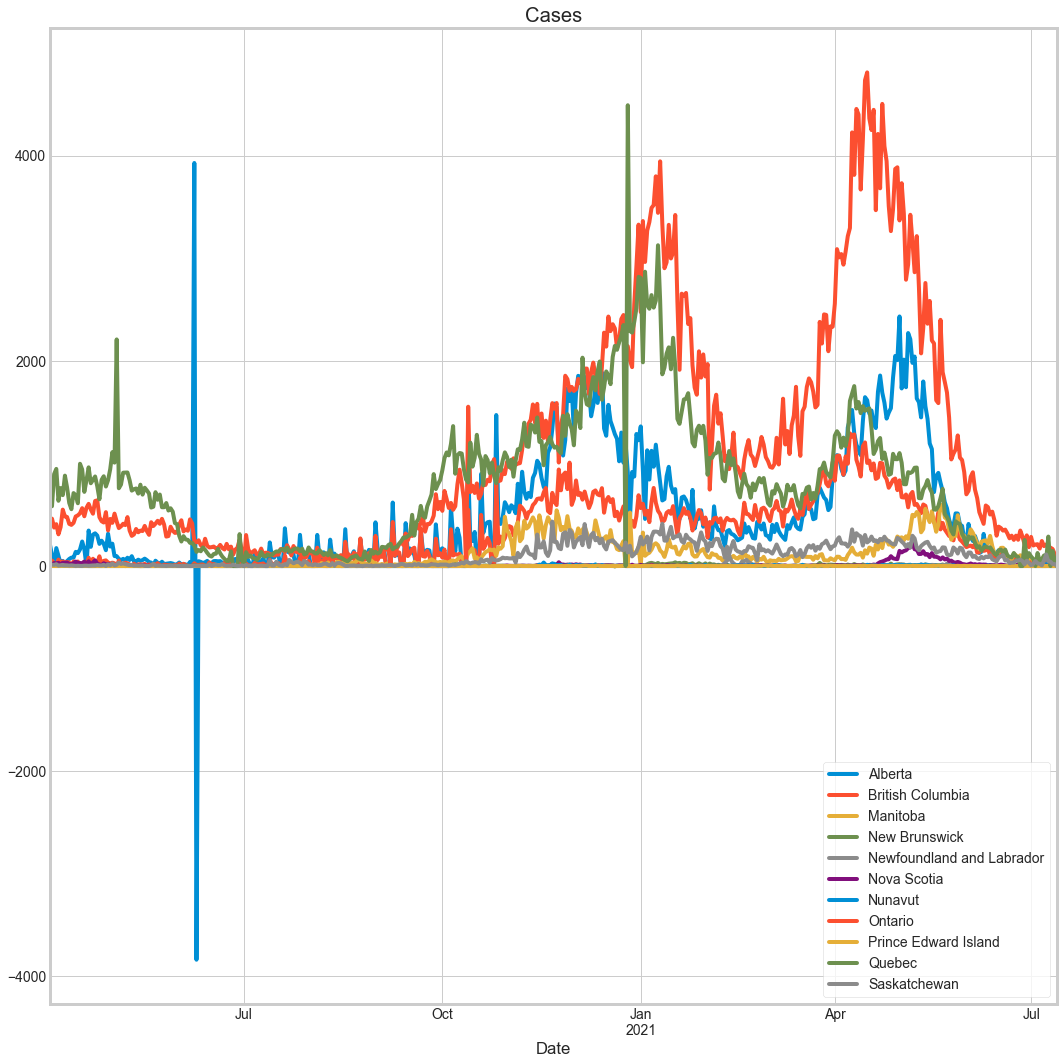

In [116]:
plt.figure(figsize = (15,15))
ax = plt.subplot(111)
for i in provinces:
    province_df[province_df['RegionName'] == i].plot(x='Date', y='NewCases', ax = ax,
                                                     label = i, title = 'Cases', legend = True)
plt.tight_layout()
plt.show()

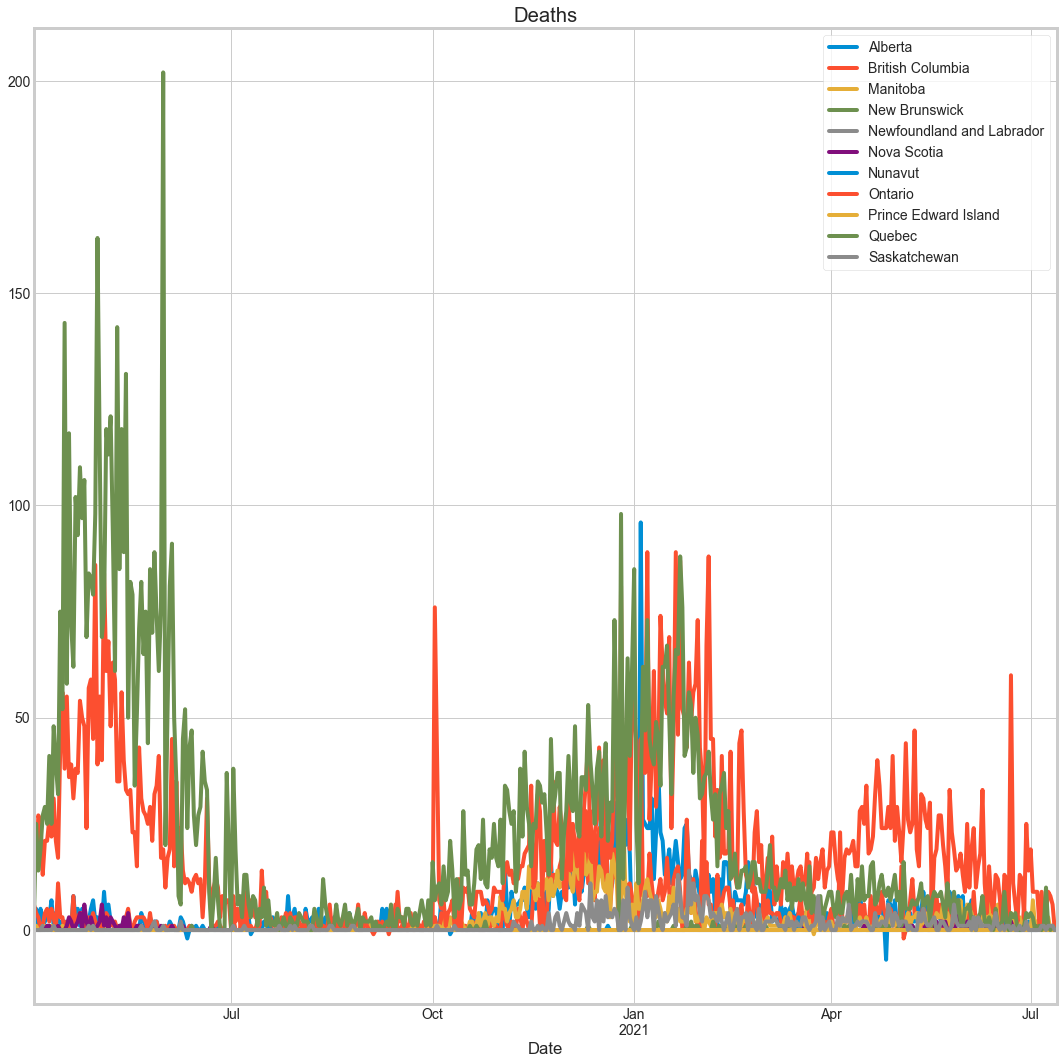

In [115]:
plt.figure(figsize = (15,15))
ax = plt.subplot(111)
for i in provinces:
    province_df[province_df['RegionName'] == i].plot(x='Date', y='NewDeaths', ax = ax,
                                                    label = i, title = 'Deaths', legend = True)

plt.tight_layout()
plt.show()

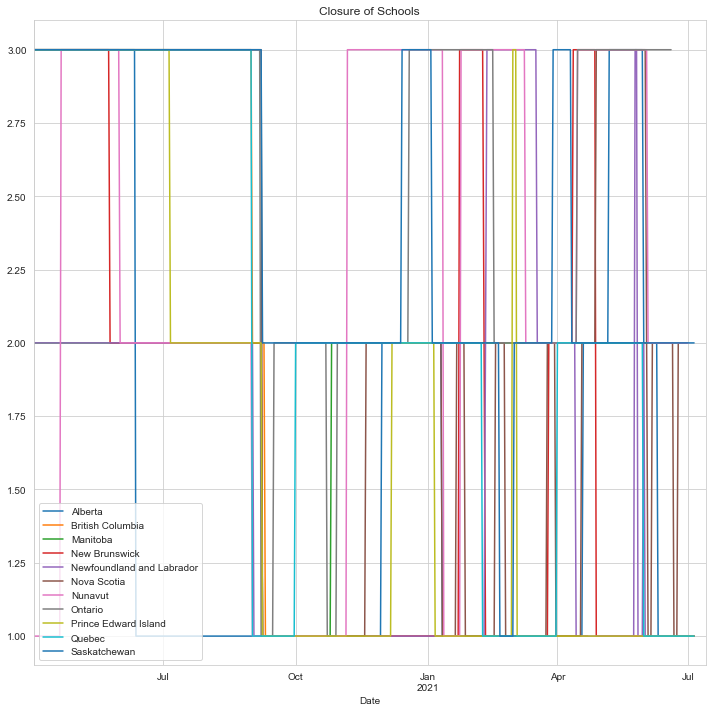

In [17]:
plt.figure(figsize = (10,10))
ax = plt.subplot()
for i in provinces:
    province_df[province_df['RegionName'] == i].plot(x='Date', y='C1_School closing', ax = ax,
                                                    label = i, title = 'Closure of Schools', legend = True)
plt.tight_layout()
plt.show()

/Users/arjunduggal/anaconda/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations



<Figure size 1440x1440 with 0 Axes>

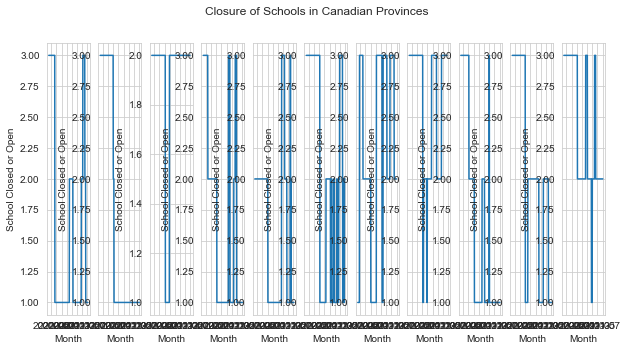

In [18]:
plt.figure(figsize = (20,20))
fig, axes = plt.subplots(1, 11, sharex=True, figsize=(10,5))
fig.suptitle('Closure of Schools in Canadian Provinces')

for i in range (0,len(provinces)):
    region = province_df[province_df['RegionName'] == provinces[i]]
    sns.lineplot(ax = axes[i], x = region['Date'], y = region['C1_School closing'])
    axes[i].set(xlabel='Month', ylabel='School Closed or Open')

plt.tight_layout()
plt.show()

## **Forecast Models**

In [19]:
canada_df = df[(df['Jurisdiction'] == 'NAT_TOTAL') & (df['CountryName'] == 'Canada')]
canada_df = canada_df[canada_df.Date > "2020-04-01"]
canada_df = canada_df.set_index('Date', drop=True)
canada_df.index.freq = 'D'
canada_df = canada_df.interpolate(limit_direction = 'forward',limit_area = 'inside')
canada_df = canada_df.dropna(subset=['ConfirmedCases'])
canada_df.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-02,Canada,CAN,NaN,NaN,NAT_TOTAL,3.0,1.0,3.0,1.0,2.0,0.0,4.0,0.0,0.0,NaN,1.0,1.0,2.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,1062591.0,0.0,0.0,NaN,0.0,NaN,3.0,0.0,11284.0,224.0,74.54,74.54,78.10,78.10,62.24,62.24,62.20,62.20,62.5,62.5
2020-04-03,Canada,CAN,NaN,NaN,NAT_TOTAL,3.0,1.0,3.0,1.0,2.0,0.0,4.0,0.0,0.0,NaN,1.0,1.0,2.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,NaN,0.0,NaN,3.0,0.0,12437.0,277.0,74.54,74.54,78.10,78.10,62.24,62.24,62.20,62.20,62.5,62.5
2020-04-04,Canada,CAN,NaN,NaN,NAT_TOTAL,3.0,1.0,3.0,0.0,2.0,0.0,4.0,0.0,0.0,NaN,1.0,1.0,2.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,NaN,0.0,NaN,3.0,0.0,12978.0,360.0,72.69,72.69,74.52,74.52,61.20,61.20,61.01,61.01,62.5,62.5
2020-04-05,Canada,CAN,NaN,NaN,NAT_TOTAL,3.0,1.0,3.0,0.0,2.0,0.0,4.0,0.0,0.0,NaN,1.0,1.0,2.0,0.0,4.0,2.0,0.0,1.0,0.0,30000000.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,NaN,0.0,NaN,3.0,0.0,15756.0,435.0,72.69,72.69,74.52,74.52,61.20,61.20,61.01,61.01,62.5,62.5
2020-04-06,Canada,CAN,NaN,NaN,NAT_TOTAL,3.0,1.0,3.0,0.0,2.0,0.0,4.0,0.0,0.0,NaN,1.0,1.0,2.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,NaN,0.0,NaN,3.0,0.0,16563.0,520.0,72.69,72.69,74.52,74.52,61.20,61.20,61.01,61.01,62.5,62.5


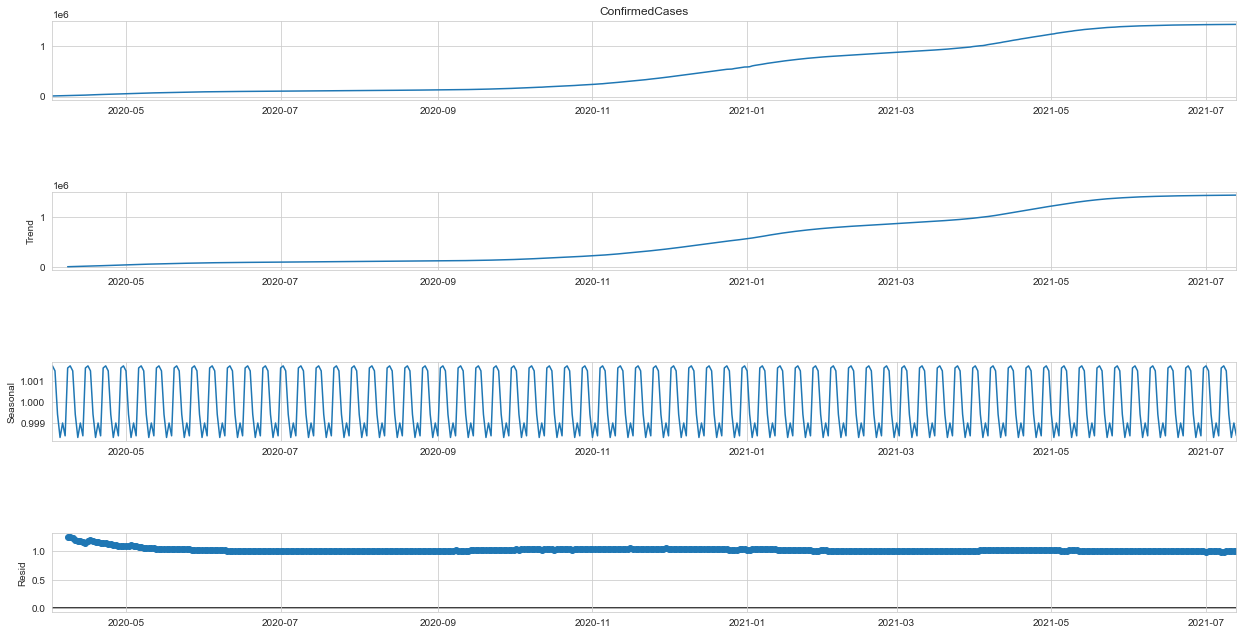

In [20]:
results = seasonal_decompose(canada_df['ConfirmedCases'], two_sided = False,
                            model = 'multiplicative')
fig = results.plot()
fig.set_size_inches((20,10))
plt.show()

Trend is upwards and weekly seasonality present in the decomposition

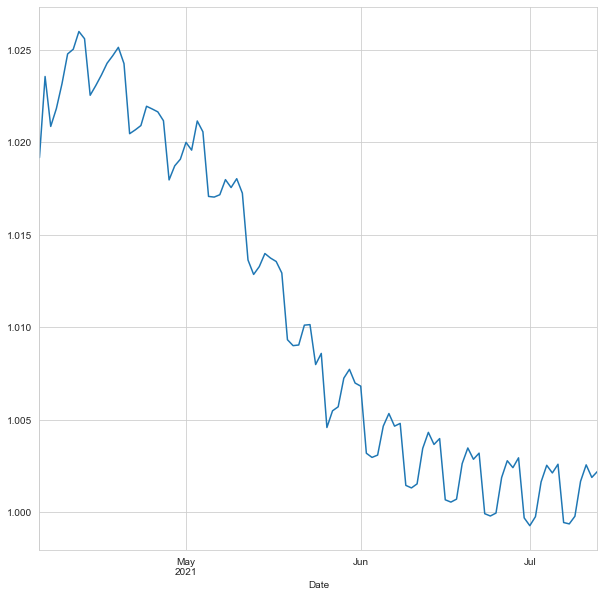

In [21]:
plt.figure(figsize = (10,10))
results.resid[-100:].plot()

## **Random Walk**
Random walk has a RMSE of 4134 cases, the error is amplified later when calculating mean absolute error. The residuals clearly indicate when peak cases occured in Canada and how over time cases are significantly dropping (following social distancing protocols and high vaccine distribution)

Random Walk RMSE
4112.763653253292


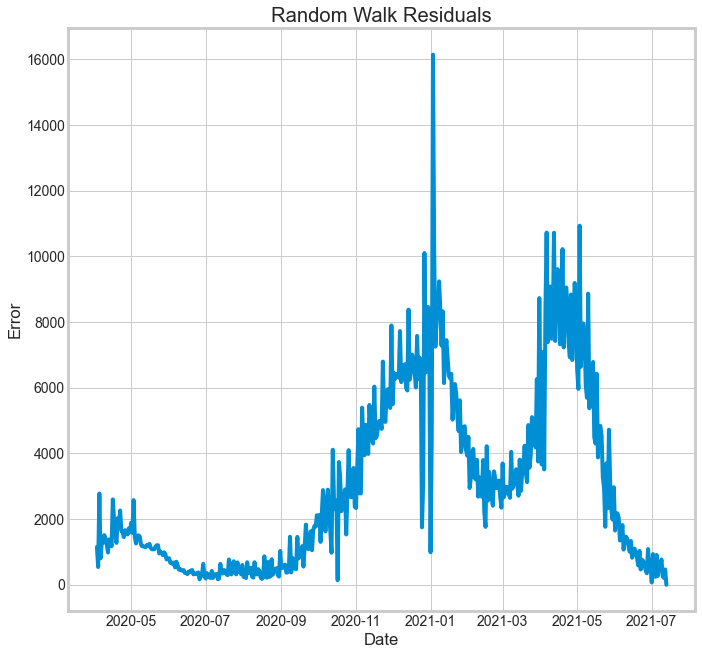

<Figure size 1080x720 with 0 Axes>

In [122]:
plt.figure(figsize = (10,10))
true = canada_df['ConfirmedCases']
pred = true.shift().fillna(0)
print('Random Walk RMSE')
RW_RMSE = np.sqrt(mean_squared_error(true,pred))
print(RW_RMSE)
plt.plot(true.index[1:],true[1:]-pred[1:], label = 'Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Random Walk Residuals')
plt.show()
plt.savefig('Random_Walk.png')

In [23]:
train = true[:-int(len(true)*.2)]
test = true[-int(len(true)*.2):]
print(test.index.date.max())
print(test.index.date.min())

2021-07-13
2021-04-12


In [24]:
simple_model = ARIMA(endog=train, order=(1,1,0), freq='d').fit()
y_hat = simple_model.predict(typ='levels')
y_hat_dy= simple_model.predict(start = test.index.min(), end= test.index.max(), typ='levels', dynamic = True)

print('FSM One-Step RMSE')
FSM_RMSE = np.sqrt(mean_squared_error(train[1:], y_hat))
print(FSM_RMSE)

print(f'FSM Dynamic RMSE from {test.index.date.min()} to {test.index.date.max()}')
print(np.sqrt(mean_squared_error(test,y_hat_dy)))


/Users/arjunduggal/anaconda/envs/test_env/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




FSM One-Step RMSE
1268.7573497861526
FSM Dynamic RMSE from 2021-04-12 to 2021-07-13
108073.6121546204


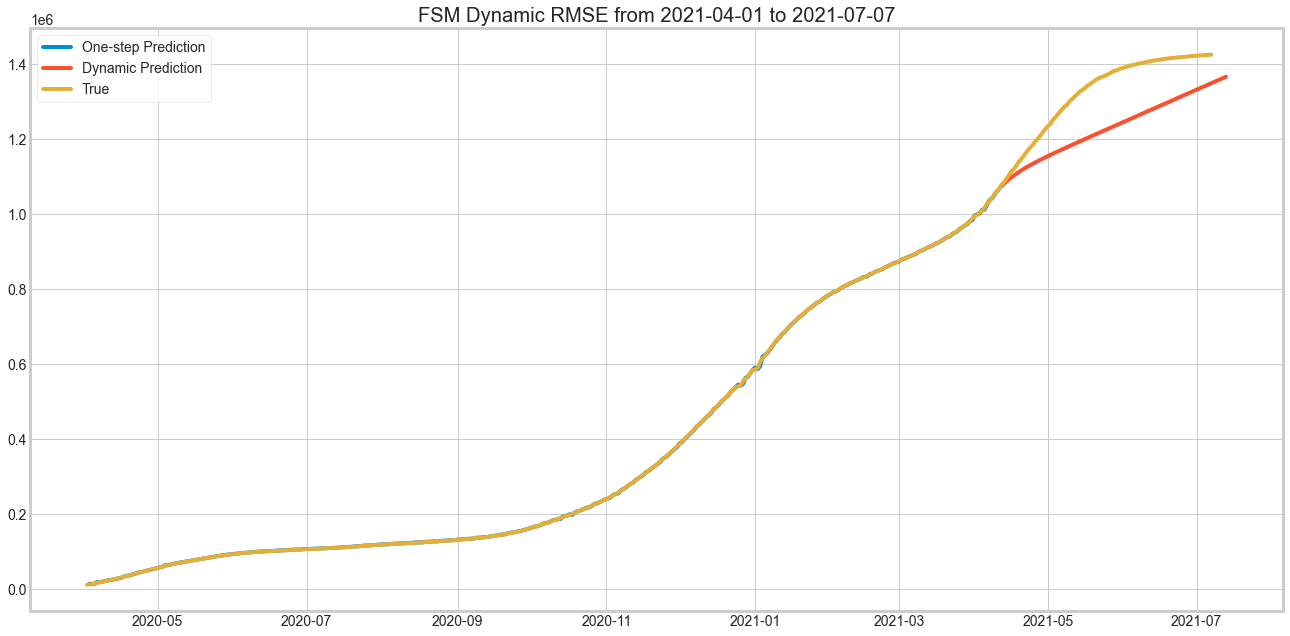

In [120]:
fig, ax = plt.subplots()
fig.set_size_inches((20,10))
ax.plot(y_hat, label = 'One-step Prediction')
ax.plot(y_hat_dy, label = 'Dynamic Prediction')
ax.set_title(f'FSM Dynamic RMSE from {test.index.date.min()} to {test.index.date.max()}')
ax.plot(true, label = 'True')
plt.legend()
plt.savefig('FSM.png')

In [26]:
canada_df

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-02,Canada,CAN,NaN,NaN,NAT_TOTAL,3.0,1.0,3.0,1.0,2.0,0.0,4.0,0.0,0.0,NaN,1.0,1.0,2.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,1062591.0,0.0,0.0,NaN,0.0,NaN,3.0,0.0,11284.0,224.0,74.54,74.54,78.10,78.10,62.24,62.24,62.20,62.20,62.5,62.5
2020-04-03,Canada,CAN,NaN,NaN,NAT_TOTAL,3.0,1.0,3.0,1.0,2.0,0.0,4.0,0.0,0.0,NaN,1.0,1.0,2.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,NaN,0.0,NaN,3.0,0.0,12437.0,277.0,74.54,74.54,78.10,78.10,62.24,62.24,62.20,62.20,62.5,62.5
2020-04-04,Canada,CAN,NaN,NaN,NAT_TOTAL,3.0,1.0,3.0,0.0,2.0,0.0,4.0,0.0,0.0,NaN,1.0,1.0,2.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,NaN,0.0,NaN,3.0,0.0,12978.0,360.0,72.69,72.69,74.52,74.52,61.20,61.20,61.01,61.01,62.5,62.5
2020-04-05,Canada,CAN,NaN,NaN,NAT_TOTAL,3.0,1.0,3.0,0.0,2.0,0.0,4.0,0.0,0.0,NaN,1.0,1.0,2.0,0.0,4.0,2.0,0.0,1.0,0.0,30000000.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,NaN,0.0,NaN,3.0,0.0,15756.0,435.0,72.69,72.69,74.52,74.52,61.20,61.20,61.01,61.01,62.5,62.5
2020-04-06,Canada,CAN,NaN,NaN,NAT_TOTAL,3.0,1.0,3.0,0.0,2.0,0.0,4.0,0.0,0.0,NaN,1.0,1.0,2.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,NaN,0.0,NaN,3.0,0.0,16563.0,520.0,72.69,72.69,74.52,74.52,61.20,61.20,61.01,61.01,62.5,62.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-09,Canada,CAN,NaN,NaN,NAT_TOTAL,3.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,3.0,0.0,5.0,1.0,2.0,1.0,1427475.0,26383.0,69.91,69.91,72.14,72.14,71.88,71.88,73.21,73.21,62.5,62.5
2021-07-10,Canada,CAN,NaN,NaN,NAT_TOTAL,3.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,3.0,0.0,5.0,1.0,2.0,1.0,1427732.0,26389.0,69.91,69.91,72.14,72.14,71.88,71.88,73.21,73.21,62.5,62.5
2021-07-11,Canada,CAN,NaN,NaN,NAT_TOTAL,3.0,0.0,2.0,0.0,2.0,0.0,4.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,3.0,0.0,5.0,1.0,2.0,1.0,1427941.0,26396.0,69.91,69.91,72.14,72.14,71.88,71.88,73.21,73.21,62.5,62.5


In [27]:
m = Prophet()

In [28]:
df

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174715,Zimbabwe,ZWE,NaN,NaN,NAT_TOTAL,2021-07-09,0.0,NaN,2.0,1.0,2.0,1.0,4.0,1.0,0.0,NaN,2.0,1.0,2.0,1.0,2.0,0.0,NaN,0.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,3.0,1.0,5.0,1.0,0.0,NaN,65066.0,2084.0,64.81,64.81,60.71,60.71,53.65,53.65,61.31,61.31,0.0,0.0
174716,Zimbabwe,ZWE,NaN,NaN,NAT_TOTAL,2021-07-10,0.0,NaN,2.0,1.0,2.0,1.0,4.0,1.0,0.0,NaN,2.0,1.0,2.0,1.0,2.0,0.0,NaN,0.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,3.0,1.0,5.0,1.0,0.0,NaN,66853.0,2126.0,64.81,64.81,60.71,60.71,53.65,53.65,61.31,61.31,0.0,0.0
174717,Zimbabwe,ZWE,NaN,NaN,NAT_TOTAL,2021-07-11,0.0,NaN,2.0,1.0,2.0,1.0,4.0,1.0,0.0,NaN,2.0,1.0,2.0,1.0,2.0,0.0,NaN,0.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,3.0,1.0,5.0,1.0,0.0,NaN,67765.0,2185.0,64.81,64.81,60.71,60.71,53.65,53.65,61.31,61.31,0.0,0.0
174718,Zimbabwe,ZWE,NaN,NaN,NAT_TOTAL,2021-07-12,0.0,NaN,2.0,1.0,2.0,1.0,4.0,1.0,0.0,NaN,2.0,1.0,2.0,1.0,2.0,0.0,NaN,0.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,3.0,1.0,5.0,1.0,0.0,NaN,70426.0,2236.0,64.81,64.81,60.71,60.71,53.65,53.65,61.31,61.31,0.0,0.0


## **Plotting New Cases**

In [59]:
def get_simple_covid_data():
    """
    Download latest confirmed cases and deaths from Oxford by both provinces and countries.
    Create new cases and new deaths columns as the running difference in the confirmed cases and deaths, 
    which are cumulative.
    return resulting dataframe
    """
    #download latest data from Oxford
    DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
    df = pd.read_csv(DATA_URL,
                    parse_dates=['Date'],
                    encoding="ISO-8859-1",
                    dtype={"RegionName": str},
                    error_bad_lines=False,
                    usecols = ['Date','Jurisdiction','RegionName',
                               'CountryName','ConfirmedCases','ConfirmedDeaths'])
    
    #forward fill NaNs in confirmed cases and confirmed deaths columns
    #if January 1st is NaN, set to 0
    df.loc[(df.Date == '2020-01-01') & (df['ConfirmedCases'].isna()), 'ConfirmedCases'] = 0
    df.loc[(df.Date == '2020-01-01') & (df['ConfirmedDeaths'].isna()), 'ConfirmedDeaths'] = 0
    df[['ConfirmedCases','ConfirmedDeaths']] = df[['ConfirmedCases','ConfirmedDeaths']].fillna(method = 'ffill')

    #add new cases and new deaths columns
    for state in df[(df['Jurisdiction'] == 'STATE_TOTAL')]['RegionName'].unique():
        state_inds = (df['Jurisdiction'] == 'STATE_TOTAL') & (df['RegionName'] == state)
        df.loc[state_inds, 'NewCases'] = df.loc[state_inds, 'ConfirmedCases'].diff().fillna(0)
        df.loc[state_inds, 'NewDeaths'] = df.loc[state_inds, 'ConfirmedDeaths'].diff().fillna(0)

    for country in df[(df['Jurisdiction'] == 'NAT_TOTAL')]['CountryName'].unique():
        nat_inds = (df['Jurisdiction'] == 'NAT_TOTAL') & (df['CountryName'] == country)
        df.loc[nat_inds, 'NewCases'] = df.loc[nat_inds, 'ConfirmedCases'].diff().fillna(0)
        df.loc[nat_inds, 'NewDeaths'] = df.loc[nat_inds, 'ConfirmedDeaths'].diff().fillna(0)
        
    return df

In [60]:
#'country' or 'state'
division = 'country'
region = 'Canada'
#'ConfirmedCases' or 'ConfirmedDeaths'
prediction = 'ConfirmedCases'

In [61]:
#remove unneeded columns and set date as index (necessary for SARIMA model)
full_df = get_simple_covid_data()
if division == 'country':
    df = full_df[(full_df['Jurisdiction'] == 'NAT_TOTAL') & (full_df['CountryName'] == region)][:-1]
elif division == 'state':
    df = full_df[(full_df['Jurisdiction'] == 'STATE_TOTAL') & (full_df['RegionName'] == region)][:-1]

df = df.set_index('Date', drop=True)
df = df[df.index > "2020-04-01"]
df = df.iloc[:,3:]
# cols = [c for c in df.columns if (c.lower()[-10:] != 'fordisplay') and (c.lower()[-4:] != 'flag')]
# df = df[cols]


In [62]:
df

,ConfirmedCases,ConfirmedDeaths,NewCases,NewDeaths
Date,,,,
2020-04-02,11284.0,224.0,1724.0,49.0
2020-04-03,12437.0,277.0,1153.0,53.0
2020-04-04,12978.0,360.0,541.0,83.0
2020-04-05,15756.0,435.0,2778.0,75.0
2020-04-06,16563.0,520.0,807.0,85.0
...,...,...,...,...
2021-07-08,1426705.0,26375.0,583.0,19.0
2021-07-09,1427475.0,26383.0,770.0,8.0
2021-07-10,1427732.0,26389.0,257.0,6.0


In [63]:
#drop columns with no data and forward-fill missing data after first non nan value
df = df.dropna(how='all', axis=1)
df = df.fillna(method = 'ffill')

#remove days before first infections
df = df[df[prediction] > 0]

In [64]:
#train-test split
train_df = df[(df.index >= "2020-04-01")&(df.index < '2021-04-01')]
test_df = df[(df.index >= '2021-04-01') & (df.index < '2021-07-08')]

train = train_df[prediction]
test = test_df[prediction]
true = df[prediction]
train.index.freq = 'D'
test.index.freq = 'D'
true.index.freq = 'D'
additional_regressors = df.drop(columns = [col for col in df.columns if col in ['ConfirmedDeaths','ConfirmedCases']])


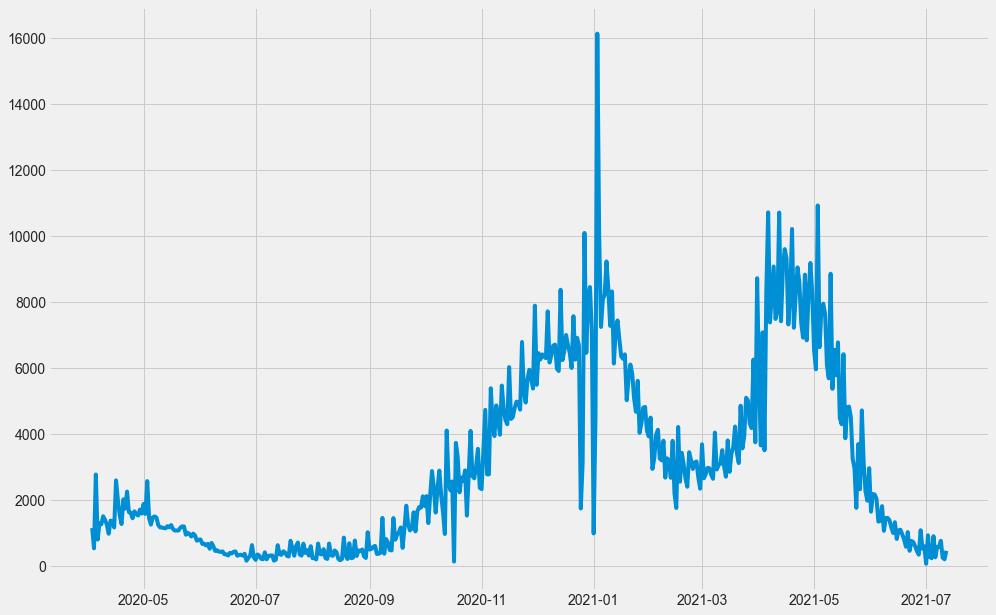

In [65]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15,10)
# differencing of one day turns total cases into daily new cases
# by tracking the change rather than the total
plt.plot(df['ConfirmedCases'].diff(1)[:])

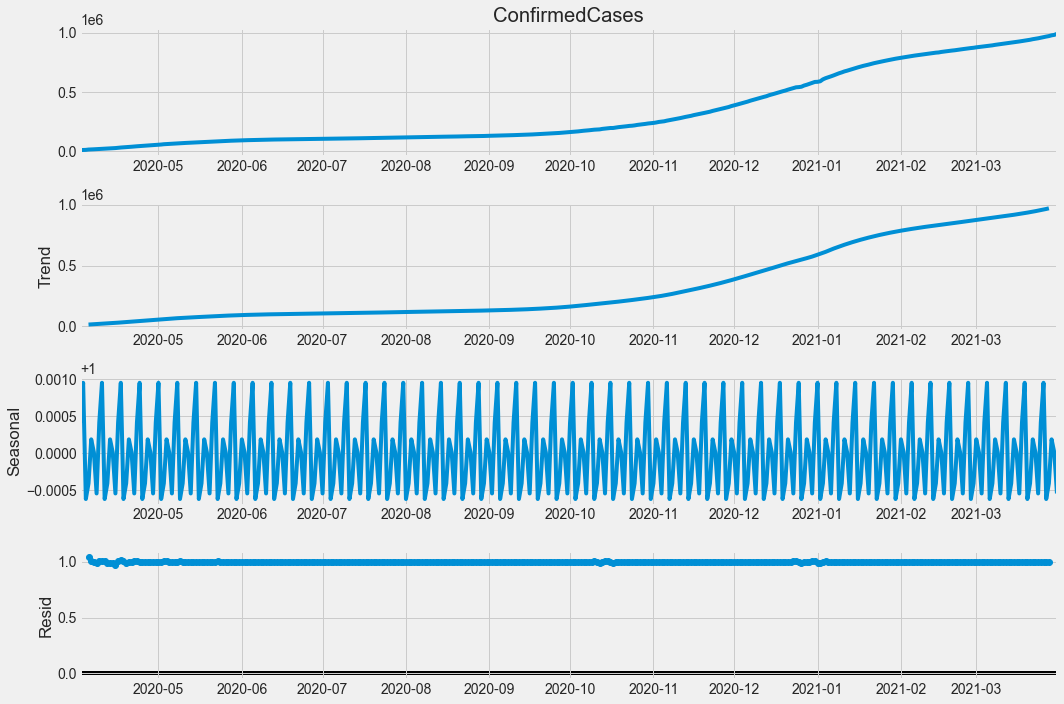

In [66]:
results = seasonal_decompose(train_df['ConfirmedCases'],two_sided = True, model='multiplicative')
results.plot()
plt.show()

Text(0.5, 0, 'Day of the Week')

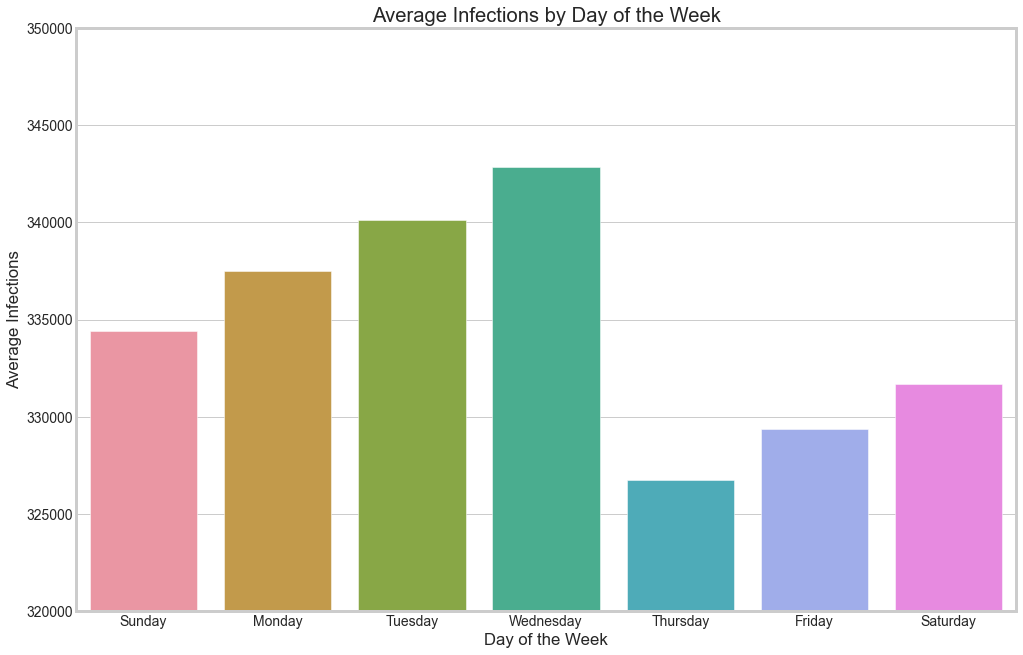

In [119]:
import seaborn as sns
ax = plt.subplot()
sns.barplot(x=train_df.index.day_name(), y=train_df[prediction].values, ax=ax, ci=False,
           order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
ax.set_ylim([320000,350000])
ax.set_title('Average Infections by Day of the Week')
ax.set_ylabel('Average Infections')
ax.set_xlabel('Day of the Week')

The above bar plot of average infections per day of the week suggests that test results are most often reported on Mondays and least often reported on Thursdays. The number of reports seems to escalate steadily from Thusday to the following Wednesday. It seems unlikely that these numbers represent the days people are actually infected on. I imagine the data is entered sometime after tests come back, which is between 2 and 5 days after testing. PCR tests are most accurate 5+ days after exposure, so we can assume reported cases lag by 7-10 days. I would guess that the greater number of reports on Wednesdays has to do with either the workflow patterns in laboratories, or the patterns of when people tend to go in for tests.

## **SARIMA and Checking for Stationarity in Time Series**

In [87]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

In [107]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape



def percentage_error(Y_actual, Y_predicted):
    res = np.empty(Y_actual.shape)
    for j in range(Y_actual.shape[0]):
        if Y_actual[j] != 0:
            res[j] = (Y_actual[j] - Y_predicted[j]) / Y_actual[j]
        else:
            res[j] = Y_predicted[j] / np.mean(Y_actual)
    return res

In [86]:
cbrt_train =  np.cbrt(train)
train = train_df[prediction]
test = test_df[prediction]
true = df.loc[df.index < '2021-07-08',prediction]
train.index.freq = 'D'
test.index.freq = 'D'
true.index.freq = 'D'

Can we remove the Seasonality present in our data with lagged differencing

(-0.4085774497616749,
 0.9086567698126125,
 12,
 449,
 {'1%': -3.4449982835447894,
  '5%': -2.8679986379826814,
  '10%': -2.5702102140862397},
 7332.076649804683)

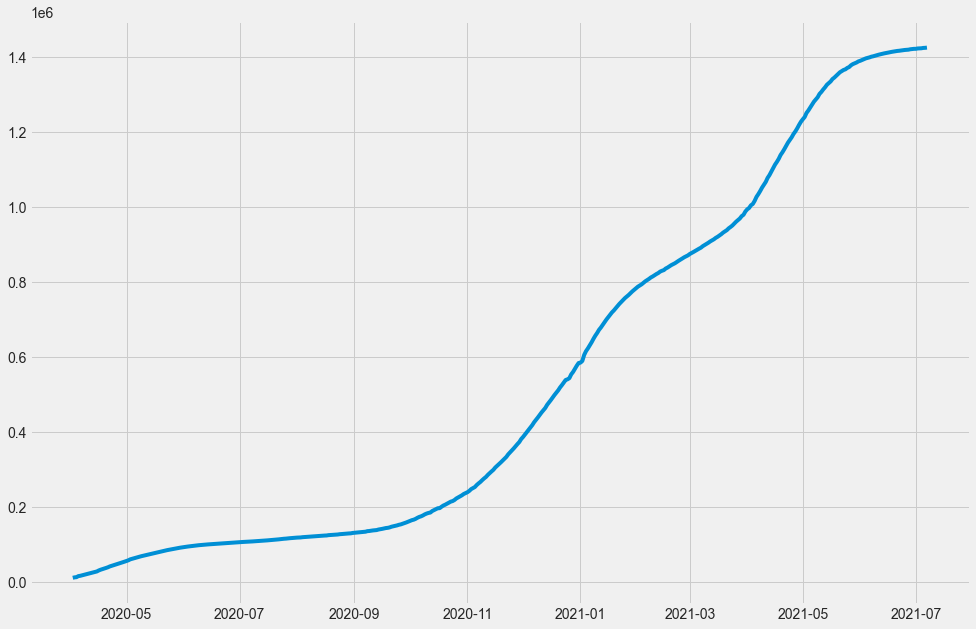

In [88]:
plt.plot(true)
adfuller(true)

(-1.8122349975899317,
 0.6988290230762861,
 11,
 449,
 {'1%': -3.979075299508393,
  '5%': -3.420313496191384,
  '10%': -3.1328282910010268},
 7373.493346848029)

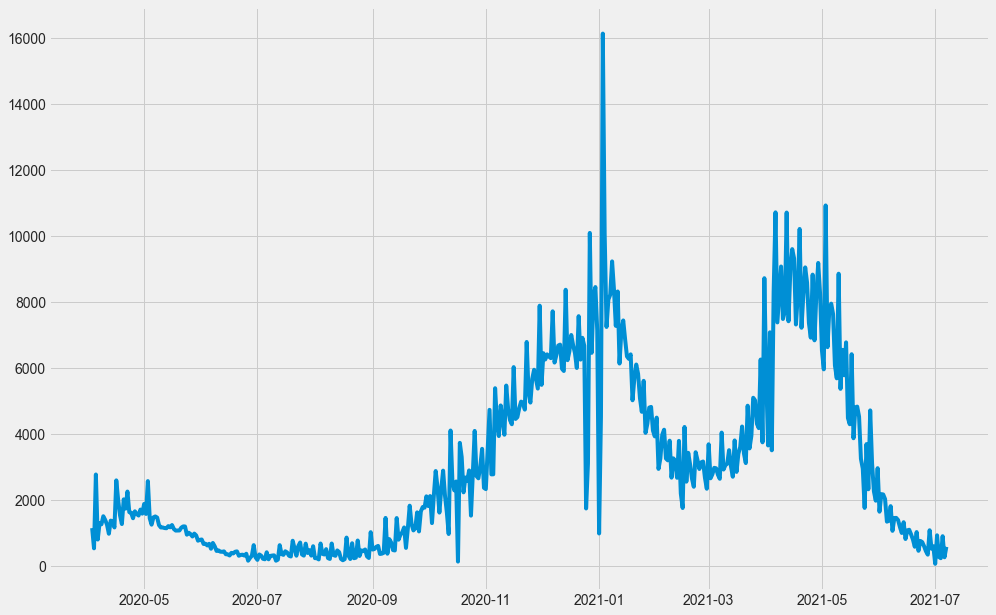

In [89]:
train_diff = true.diff(1).dropna()
plt.plot(train_diff)
adresults = adfuller(train_diff, autolag = 'BIC', regression = 'ct')
adresults

First order differencing, transforms cumulative cases into daily new cases. This makes our data stationary at a lag of 11. Now lets try second order differencing

(-1.9766353426091317,
 0.6141016083096833,
 7,
 447,
 {'1%': -3.9791667980573573,
  '5%': -3.4203576551498176,
  '10%': -3.132854234379403},
 7358.230226773296)

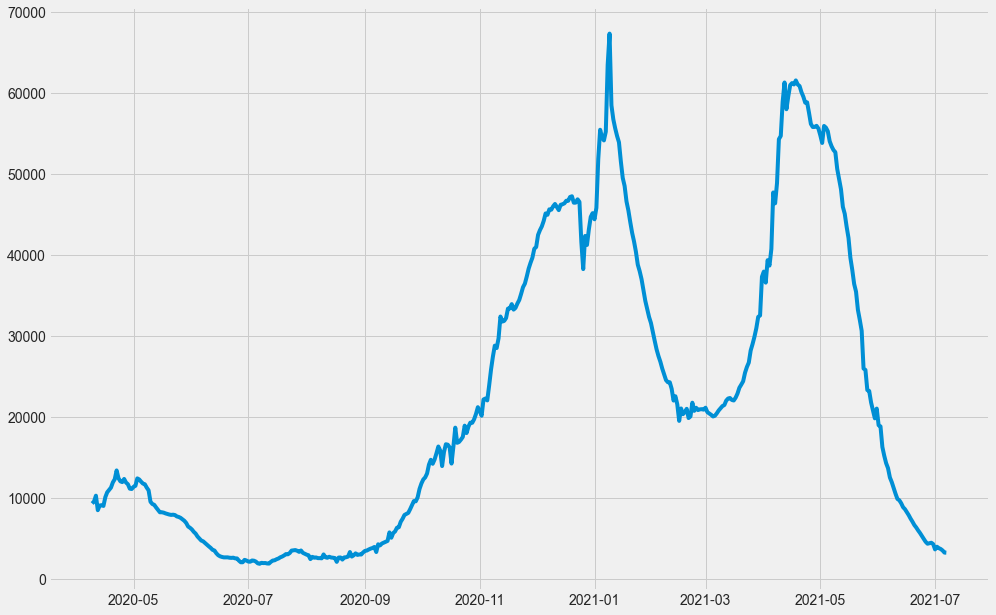

In [90]:
train_diff_week = true.diff(7).dropna()
plt.plot(train_diff_week)
adresults = adfuller(train_diff_week, autolag = 'BIC', regression = 'ct')
adresults

Let's try a second order differencing to remove the trend as well. This will be equivalent to the ARIMA model having a difference of 1 and the seasonal adjustment a difference of 7.

(-4.390674014102314,
 0.0022659067734920107,
 6,
 453,
 {'1%': -3.978894743300259,
  '5%': -3.4202263534901265,
  '10%': -3.132777093860277},
 7435.309432669946)

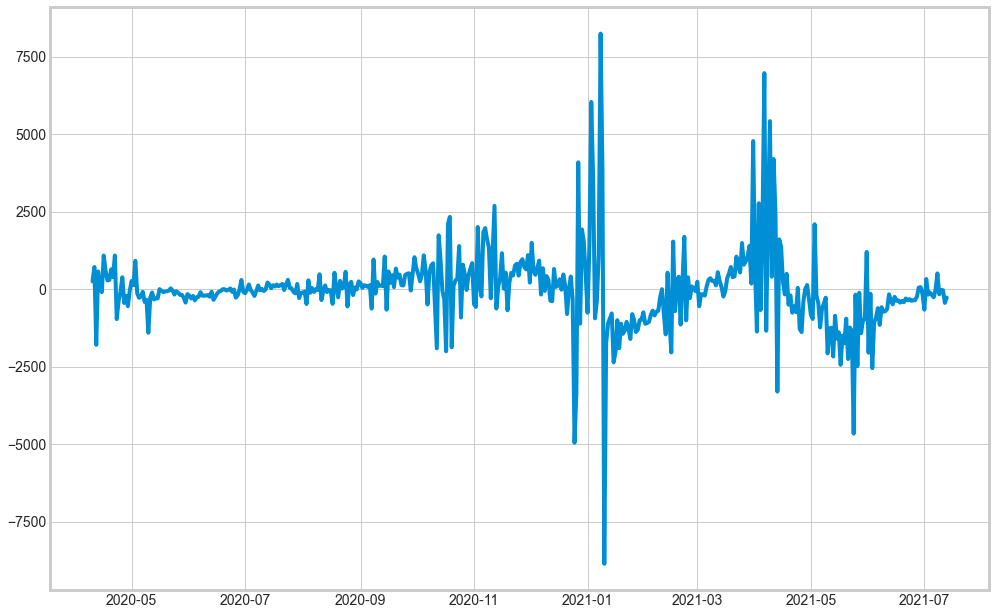

In [123]:
train_diff_week2 = true.diff(7).diff(1).dropna()
plt.plot(train_diff_week2)
adresults = adfuller(train_diff_week2, autolag = 'BIC', regression = 'ct')
adresults

The second order differencing removed the trend from our data, but the variance is not constant yet. Another trick we can try is a cube root transformation to reduce the variance change.

(-3.327432736891985,
 0.06186523597219116,
 14,
 445,
 {'1%': -3.9792591249686153,
  '5%': -3.4204022129228377,
  '10%': -3.1328804117769717},
 -1238.9937756574989)

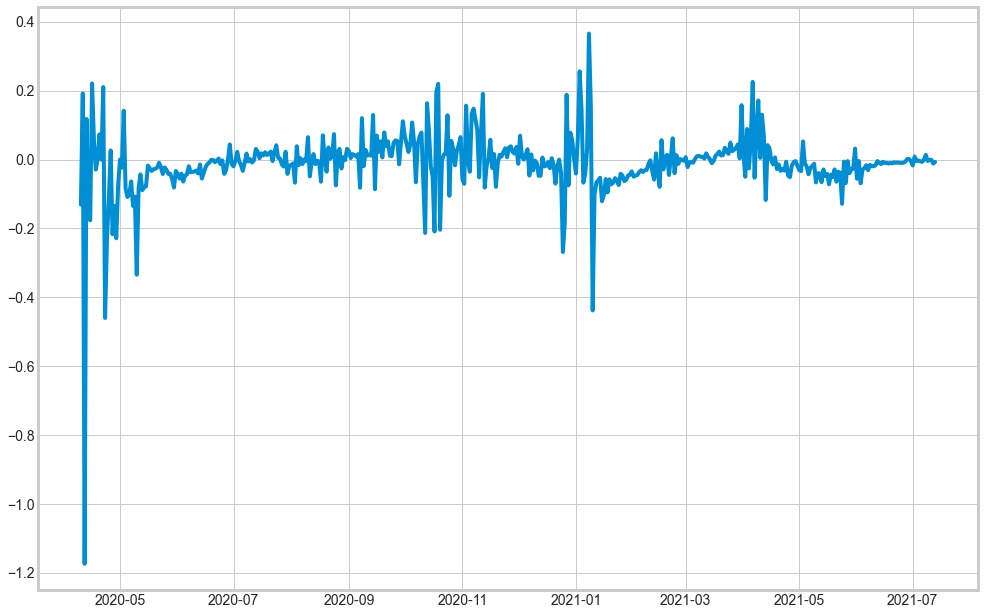

In [124]:
rolling_diff2 = np.cbrt(true).diff(7).diff(1).dropna()
plt.plot(rolling_diff2)
adresults = adfuller(rolling_diff2, autolag = 'BIC', regression = 'ct')
adresults

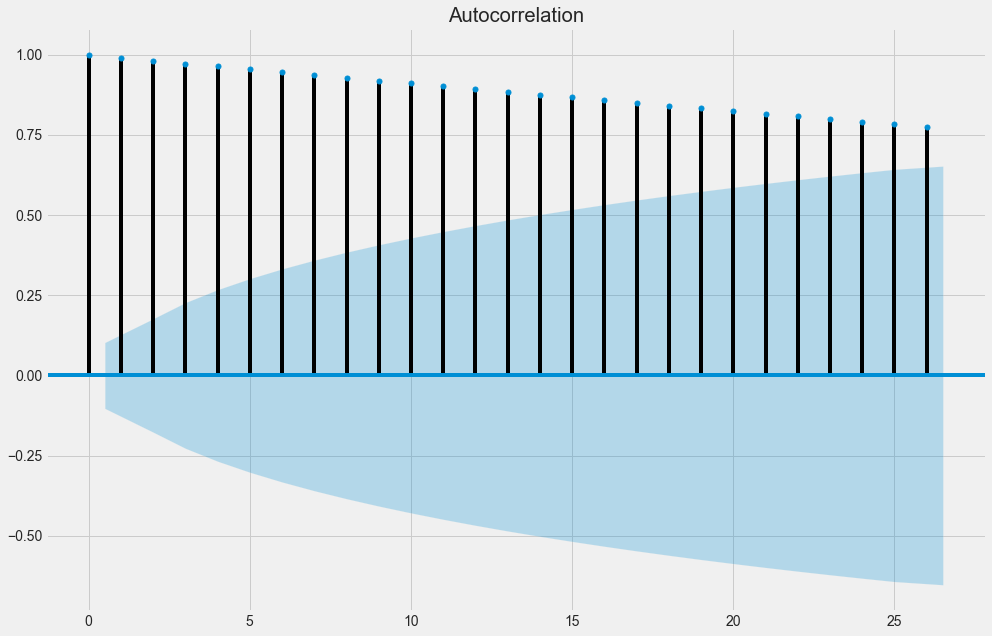

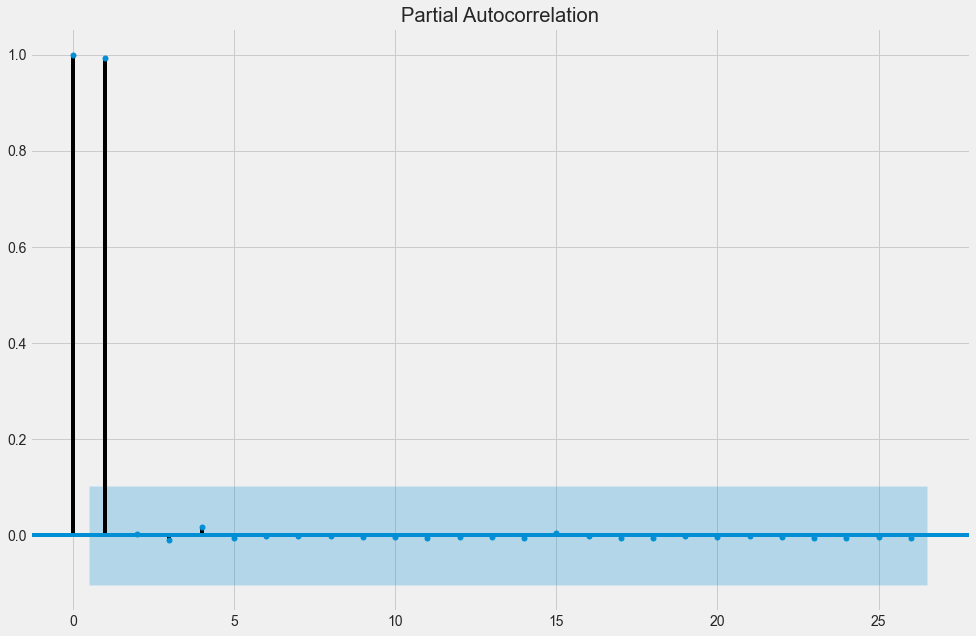

In [94]:
plot_acf(cbrt_train)
plot_pacf(cbrt_train)
plt.show()

simple arima mean absolute percent error:  16.770442735532555


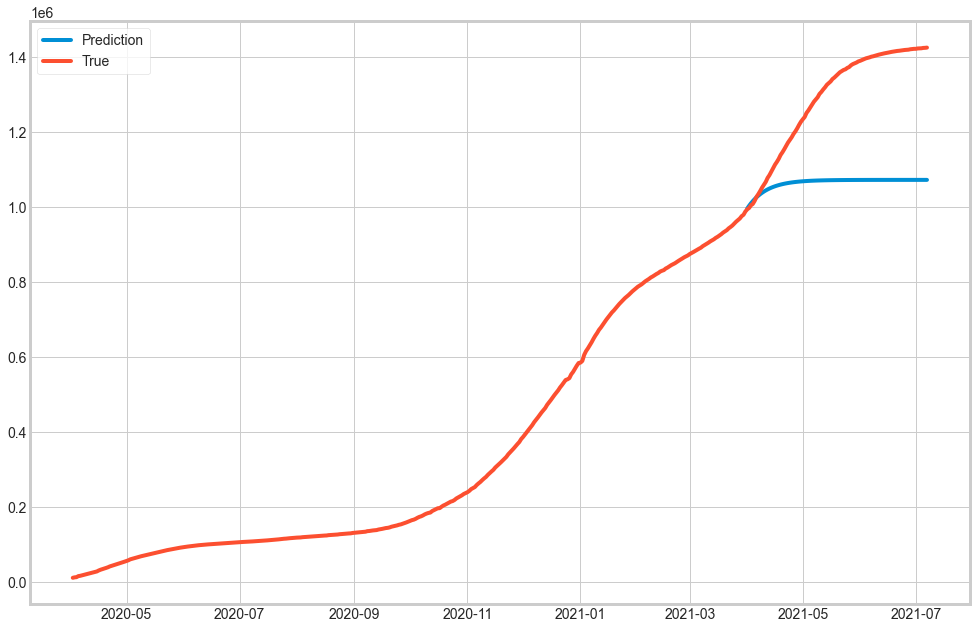

In [112]:
arimamodel = SARIMAX(cbrt_train, order = (1,1,0))
fit_model = arimamodel.fit()
yhat = fit_model.forecast(len(test))
# undo the cube root in order to compare to the test data
yhat = yhat**3

#forecast evaluation metrics
mape = MAPE(test,yhat)
mpe = percentage_error(test,yhat)
print('simple arima mean absolute percent error: ', mape)
# print('simple arima mean percent error: ', mpe)

#Plots
plt.plot(yhat, label = 'Prediction')
plt.plot(true, label = 'True')
plt.legend()
plt.show()

simple arima mean absolute percent error:  4.645137885283415


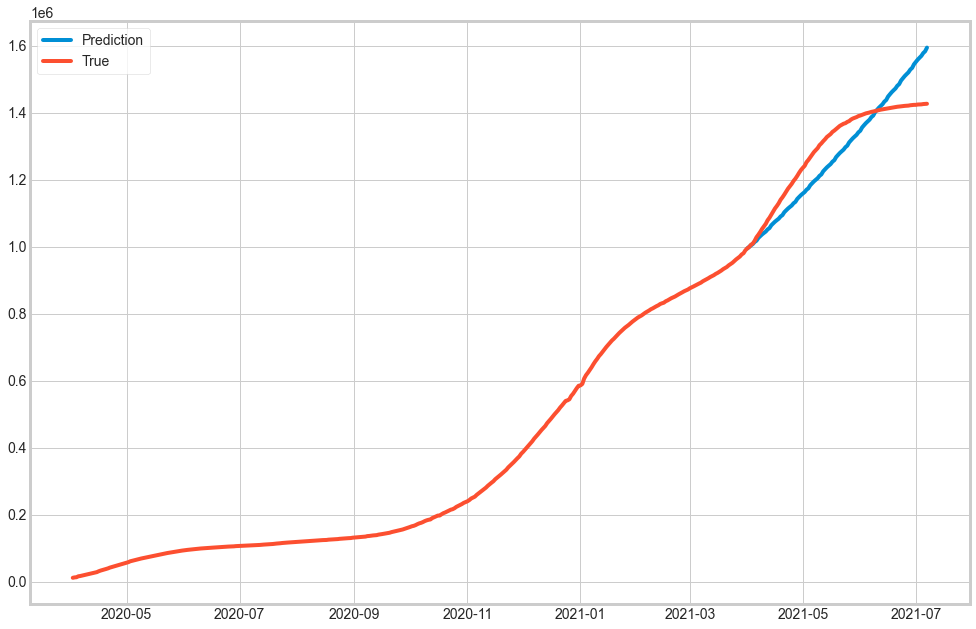

In [111]:
arimamodel = SARIMAX(cbrt_train, order = (1,1,0), seasonal_order = (1,1,0,7))
fit_model = arimamodel.fit()
yhat = fit_model.forecast(len(test))
# undo the cube root in order to compare to the test data
yhat = yhat**3

#forecast evaluation metrics
mape = MAPE(test,yhat)
mpe = percentage_error(test,yhat)
# print('simple arima mean percent error: ', mpe)
print('simple arima mean absolute percent error: ', mape)

#Plots
plt.plot(yhat, label = 'Prediction')
plt.plot(true, label = 'True')
plt.legend()
plt.show()